# Online model selection through bandit learning

---

### 0. Packages imports and functions definitions

#### NB options

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

### Constants

In [2]:
FIGSIZE = (10, 6)

#### Packages imports

In [3]:
from collections import namedtuple
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from river import (
    optim,
    datasets,
    preprocessing,
    linear_model,
    metrics,
    compose
)
from river.expert import (
    EpsilonGreedyRegressor,
    UCBRegressor,
)
from river.stream import iter_sklearn_dataset

In [4]:
from river.expert.bandit import Bandit
import river.base as base


class RandomBandit(Bandit):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _pull_arm(self):
        random_arm = np.random.choice(self._n_arms)
        return random_arm

    def _update_arm(self, arm, reward):
        pass


class RandomBanditRegressor(RandomBandit, base.Regressor):
    """Random Bandit Regressor.

    Does random selection and update of models. It is just created for testing purpose
    """

    def _pred_func(self, model):
        return model.predict_one

    
class Exp3Bandit(Bandit):
    def __init__(self, eta=0.5, **kwargs):
        super().__init__(**kwargs)
        self._p = np.ones(self._n_arms, dtype=np.float)
        self._sum_expected_reward = np.zeros(self._n_arms, dtype=np.float)
        self.eta = eta

    def _make_distr(self):
        # substracting the median to counter numerical instability.
        s_hat = self._sum_expected_reward  - np.median(self._sum_expected_reward)
        numerator = np.exp(self.eta * s_hat)
        return numerator / np.sum(numerator)

    def _pull_arm(self):
        self._p = self._make_distr()
        chosen_arm = np.random.choice(a=range(self._n_arms), p=self._p)
        return chosen_arm

    def _update_arm(self, arm, reward):
        x_hat = np.array(
            [1 - ((1 - reward) / self._p[a]) if a == arm else 1 for a in range(self._n_arms)]
        )
        self._sum_expected_reward += x_hat


class Exp3Regressor(Exp3Bandit, base.Regressor):
    """Exp3 implementation from Lattimore and Szepesvári.

    The algorithm makes the hypothesis that the reward is in [0, 1].

    Parameters
    ----------
    models
        The models to compare.
    metric
        Metric used for comparing models with.
    eta
        Parameter for exploration. The closer to zero, the more exploration.

    References
    ----------
    [^1]: [Lattimore, T., & Szepesvári, C. (2020). Bandit algorithms. Cambridge University Press.](https://tor-lattimore.com/downloads/book/book.pdf)
    [^2]: [Auer, P., Cesa-Bianchi, N., Freund, Y., & Schapire, R. E. (2002). The nonstochastic multiarmed bandit problem. SIAM journal on computing, 32(1), 48-77.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.21.8735&rep=rep1&type=pdf)
    """

    def _pred_func(self, model):
        return model.predict_one


### Functions for data generation

In [5]:
def make_xy_numpy(N=1000, p=10, intercept=0.0, seed=None, drift=False, noise_scale=.5, scale_beta=1, shock=None):
    N = int(N)
    
    if seed:
        np.random.seed(seed)

    beta = np.random.uniform(-1*scale_beta, 1*scale_beta, p)
    
    if shock:
        tier = N // 3
        beta[tier:(2 * tier)] += np.random.uniform(-1, 1, len(beta[tier:(2 * tier)]))
        beta[(2 * tier):] += np.random.uniform(-1, 1, len(beta[(2 * tier):]))

    x_arr = np.random.normal(size=(N, p))
    noise = np.random.normal(size=N, scale=noise_scale)
    xb = intercept + np.sum(x_arr * beta, axis=1) 
    
    if drift:
        tier = N // 3
        xb[tier:(2 * tier)] *= -1
        xb[(2 * tier):] *= -1
        beta *= -1
    
    y_arr = xb + noise

    return x_arr, y_arr, beta


def make_dataset(**kwargs):
    Dataset = namedtuple("dat", ["target", "data", "feature_names", "beta"])
    x_arr, y_arr, beta = make_xy_numpy(**kwargs)
    dataset = Dataset(y_arr, x_arr, ["x{}".format(i) for i in range(p)], beta)
    return dataset


def make_stream(dataset=None, take=None):
    if dataset is None:
        dataset = make_dataset()
    
    gen = iter_sklearn_dataset(dataset)
    
    if take:
        return itertools.islice(gen, take)
    else:
        return gen


### Functions for pipeline/models generation

In [6]:
l2_val = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lr_val = [0.1, 0.01, 0.001]
optimz = [optim.Adam]
scalerz = [preprocessing.StandardScaler, preprocessing.MaxAbsScaler, preprocessing.MinMaxScaler, preprocessing.RobustScaler]

def make_models(lr=0.35):
    grid = itertools.product(
        lr_val,
        l2_val,
        scalerz,
        optimz
    )    
    return [
        make_pipeline(lr=lr, l2=l2, scaler=scaler, optimizer=optimizer)
        for (lr, l2, scaler, optimizer) in grid
    ]

def make_pipeline(lr=0.1, l2=0, scaler=None, optimizer=None):
    #if scaler is None:
    #scaler =  preprocessing.StandardScaler()
    if optimizer is None:
        optimizer = optim.SGD

    pipeline = compose.Pipeline(
        scaler,
        linear_model.LinearRegression(optimizer=optimizer(), l2=l2)
    )
    return pipeline

# 1. Simulation

## 1.1. Layout

We simulate a **dataset** with : 
- 10 000 observations
- 25 features that are iid $\mathcal{N}(0, 1)$.
- $\beta$ vector is distributed as $\mathcal{U}([0, 1])$
- The data generating process (DGP) is linear : $y=X^T\beta + \epsilon$ with $\epsilon$ ~ $\mathcal{N}(0, 1)$

In [7]:
N = 3_000
p = 25
dataset = make_dataset(p=p, N=N, intercept=2, drift=False, noise_scale=.5, shock=False, seed=123, scale_beta=3)

In [8]:
use_oracle = False
use_provided_compute = False

In [10]:
seed = np.random.seed(1)

def make_default_params():
    return dict(metric=metrics.MAE(), 
                models=make_models(),
                seed=seed,
                explore_each_arm=1, 
                start_after=100,
               )

In [12]:
bandits = {
    "epsilon" : EpsilonGreedyRegressor(epsilon=0.1, **make_default_params()),
    'exp3': Exp3Regressor(**make_default_params()),
    "ucb"     : UCBRegressor(**make_default_params()),
    "random"  : RandomBanditRegressor(**make_default_params()),
}

#bandit_oracle = OracleBandit(**make_default_params())

l = []
avg_reward = []

for i, (x, y) in tqdm.tqdm(enumerate(make_stream(dataset))):    
#for i, (x, y) in tqdm.tqdm(enumerate(datasets.Phishing())):    
#for i, (x, y) in tqdm.tqdm(enumerate(datasets.TrumpApproval())): 

    for bandit_label in bandits:
        y_pred = bandits[bandit_label].predict_one(x=x)
        reward, metric, chosen_arm = bandits[bandit_label]._learn_one(x=x, y=y)

        # Saving info into lists
        l.append((bandit_label, i, reward, metric, chosen_arm))
        avg_reward.append((bandit_label, i, *bandits[bandit_label].average_reward.copy()))
    
    if use_oracle:
        oracle_pred = bandit_oracle.predict_one(x, y)
        bandit_oracle.learn_one(x=x, y=y)

# Building dataframe from lists
df_avg = pd.DataFrame(
    avg_reward,
    columns=["bandit", "iteration", *["{}".format(i) for i in range(bandits["epsilon"]._n_arms)]]
).set_index("iteration")

df_analysis = pd.DataFrame(l, columns=["bandit", "iteration", "reward", "metric", "arm"])

3000it [00:05, 517.97it/s]


# 2. Results analysis

In [13]:
panel_title_kwargs = dict(
    fontsize = 14,
    fontweight = 'bold',
)

## 2.1. Reward
### Average reward through time
- y axis : iteration
- x axis : arm/model
- fill value : average reward for this arm/model

epsilon
exp3
ucb
random


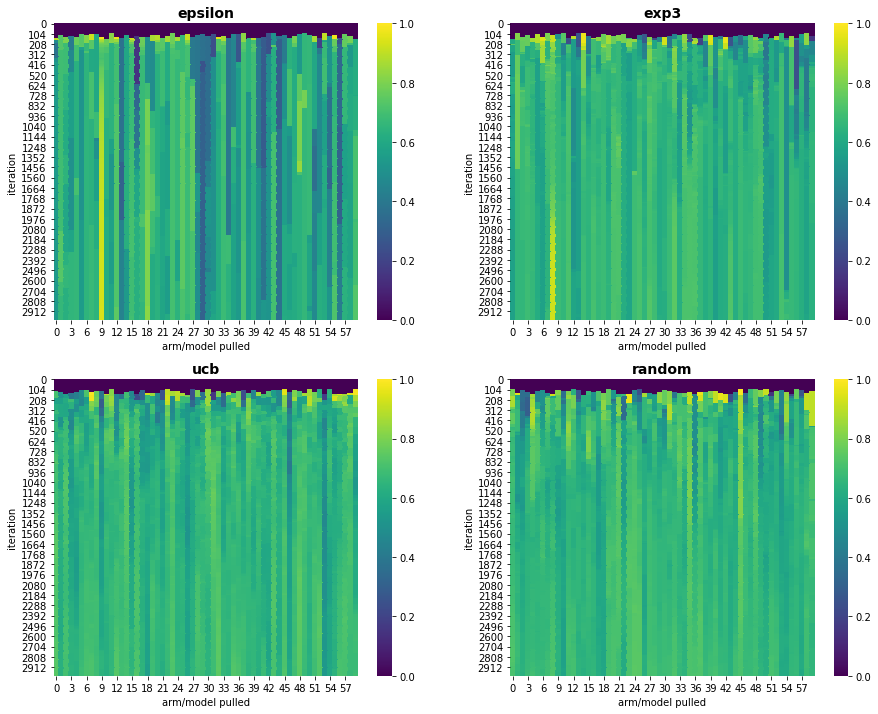

In [14]:
fig, axes = plt.subplots(figsize=(15, 12), nrows=2, ncols=2)

for (i, bandit_label) in enumerate(bandits):
    print(bandit_label)
    ax = axes[i // 2][i % 2] # i // 2 selects the row, i % 2 select the column 
    df_plot = df_avg[lambda df: df.bandit == bandit_label].drop(columns=["bandit"])
    sns.heatmap(df_plot, cmap="viridis", ax=ax, vmin=0, vmax=1)
    ax.set_title(bandit_label, **panel_title_kwargs)
    ax.set_xlabel("arm/model pulled")

### Bandits loss and reward 

The _loss_ correspond to the metric choose by the user (MSE or MAE) evaluated using the target `y` and the prediction `y_pred` that is given by the method `predict_one`. The `predict_one` method returns the prediction of the model with the highest average reward.

A rolling mean is considered.

Text(0.5, 1.0, 'Cumulated reward')

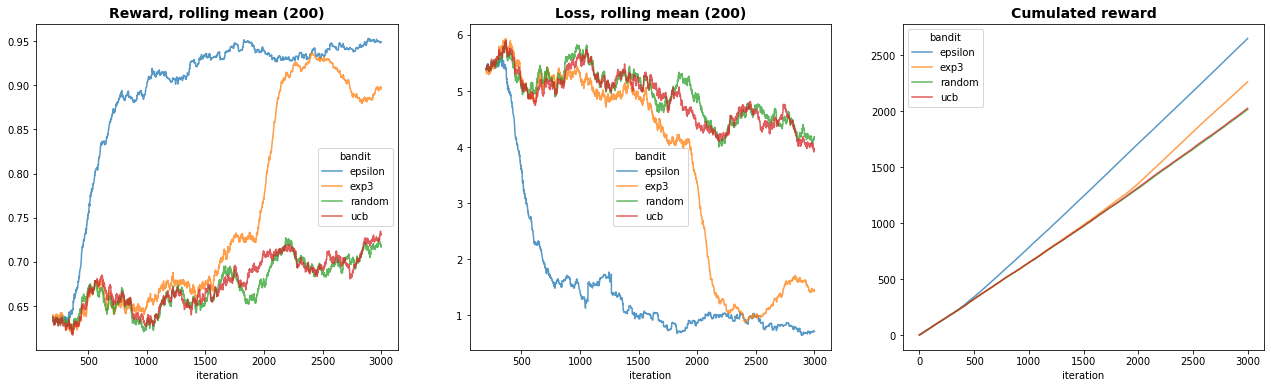

In [15]:
ROLLING_WINDOW = 200

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(22, 6), nrows=1, ncols=3)
df_analysis.pivot(index="iteration", columns="bandit", values="reward").rolling(ROLLING_WINDOW).mean().plot(alpha=.75, ax=ax1)
df_analysis.pivot(index="iteration", columns="bandit", values="metric").rolling(ROLLING_WINDOW).mean().plot(alpha=.75, ax=ax2)
df_analysis.pivot(index="iteration", columns="bandit", values="reward").cumsum().plot(alpha=.75, ax=ax3)

ax1.set_title("Reward, rolling mean ({})".format(ROLLING_WINDOW), **panel_title_kwargs)
ax2.set_title("Loss, rolling mean ({})".format(ROLLING_WINDOW), **panel_title_kwargs)
ax3.set_title("Cumulated reward", **panel_title_kwargs)

## 2.2. Times pulled

The arm pulled is the result of the exploitation/exploration process and doesn't necessary represent the best model (defined as the one that max average reward)

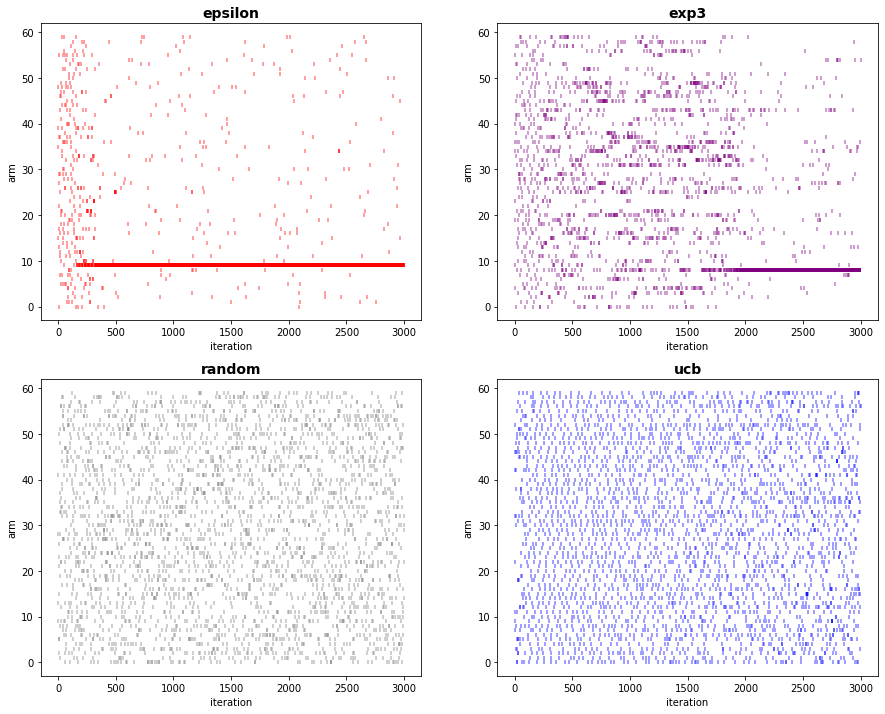

In [16]:
dcol = {
    "epsilon": "red",
    "ucb": "blue",
    "random": "gray",
    "exp3": "purple",
}

fig, axes = plt.subplots(figsize=(15, 12), nrows=2, ncols=2)

for i, (label, group) in enumerate(df_analysis.groupby("bandit")):
    ax = axes[i // 2][i % 2]
    group.plot.scatter(x="iteration", y="arm", c=dcol[label], marker="|", alpha=.5 , label=label, ax=ax, legend=False)
    ax.set_title(label, **panel_title_kwargs)

In [17]:
def arm_pull_to_count(s, q = .1):
    lst = []
    d = {}
    
    for arm in s:
        if not arm in d:
            d[arm] = 1
        else:
            d[arm] += 1
        
        lst.append(d.copy())

    df_count = pd.DataFrame(lst)#.fillna(0)
    
    if q > 0:
        threshold = np.quantile(df_count.iloc[-1], q=q)
        keep_col = list((df_count.iloc[-1] > threshold)[lambda s: s].index)
        df_count = df_count.iloc[:, keep_col]
    
    df_percent = df_count.apply(lambda s: s/sum(s), axis=1)
    return df_percent

In [18]:
arms_pulled = df_analysis.pivot(index="iteration", columns="bandit", values="arm")

In [ ]:
pct_most_pulled = 25/100
fig, axes = plt.subplots(figsize=(25, 15), nrows=2, ncols=2)

fig.suptitle(f'Repartition of the most pulled (top {round(100*pct_most_pulled)} %) arms', 
             fontsize=24, fontweight='bold', fontproperties='serif')
for (i, bandit_label) in enumerate(bandits):
    print(bandit_label)
    ax = axes[i//2][i%2]
    arm_pull_to_count(s=arms_pulled[bandit_label], q=1-pct_most_pulled).plot(
        ax=ax, kind="area", colormap="Paired", linewidth=.25
    )
    ax.set_title(bandit_label, **panel_title_kwargs)
    ax.set_ylabel('Percent (%)')
    ax.set_xlabel('Iteration')
    ax.legend(loc='lower right')
    [l.set_color("black") for l in ax.lines]
    #plt.show()

epsilon
exp3
ucb


----

---

# WORK IN PROGRESS

## 2.3. Distangling the effects of learning models from learning selection (bandit)

The loss comparison of the previous section shows that there is decrease in loss the first 4 000 observations that happen for **all** the models (even the random one).

Contrary to classical bandits, the distribution of the rewards the models also depends on **_how well_ we can fit the models**. The model fitting is directly linked to how many observations have been fed to the model : more observations = better fitting. This effect is common for all bandit (even the random one since it learn for each random arm it pulled).

Another of reason of the loss reduction is due to the **improvement in the selection of the best model by the bandits**. This improvement is not seen for the Random Bandit since it doesn't actively select model (it just pull arm randomly). 

We can approximate the share of the loss's reduction imputable to the bandit selection vs the share imputable to model learning. We thus consider the ratio : $$\frac{Loss_{random} - Loss_{bandits}}{Loss_{random}}$$ where $bandits$ are the mean of the loss the UCB and epsilon and random the loss of the random bandit.

Small caveat in using this measure: the model fitting and model selection effects is intertwined since selection of specific models will increase the model fitting as compared to the random bandit. This effects decrease over time as the random bandit update all the models.

In [14]:
c = 100

def make_compare_bandit_models_df(metric_values_df, rolling_value=250, smoothing_degree=3, trans=lambda s: c * (1 - (s / s.random))):
    selection_effect = (
        metric_values_df
        .rolling(rolling_value).mean()
        .apply(trans, axis=1)
        .drop(columns="random")
        .mean(axis=1)# average effect in both bandits
        .rename("share")
        .dropna()
        .reset_index(drop=True)
        .to_frame()
    )

    # Curve smoothing
    z = np.polyfit(selection_effect.index, selection_effect.share, deg=smoothing_degree)
    p = np.poly1d(z)
    selection_effect["smooth_share"] = [p(x) for x in selection_effect.index]
    
    return selection_effect

def make_compare_area_plot(df):

    alpha=.375
    ax = df.plot(kind="line", title="Reduction of loss attributed to model learning vs bandit selection, through time", figsize=FIGSIZE, legend=True)
    ax.title.set_fontsize(15)

    ax.set_ylim(0, c)

    ax.lines[1].set_color("blue")
    ax.lines[0].set_color("gray")
    #ax.lines[0].set_alpha(.75)
    ax.lines[0].set_linewidth(.425)
    
    ax.fill_between(df.index, 0, df.smooth_share, color="blue", alpha=alpha, label="Bandit")
    ax.fill_between(df.index, df.smooth_share, c, color="red", alpha=alpha, label="Model")

    ax.text(500, .85*c, "Improvements attributed to model learning\n(red area)")
    ax.text(df.shape[0]//4, .2*c, "Improvements loss attributed to bandit selection\n(blue area)", color="black")

    ax.legend(loc='lower right')
    
    return ax

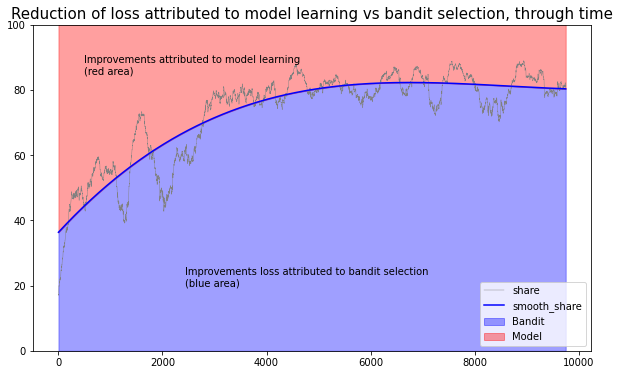

In [15]:
selection_effect = make_compare_bandit_models_df(metric_values_df, rolling_value=250, smoothing_degree=3)
ax = make_compare_area_plot(selection_effect)

We can see that the large part of the reduction in loss is imputable to the bandit selection mecanism and that this part increase over time espcially at the beginning. The increase at the beginning is due to the fact that the loss decrease for all the models in the bandits due to the effect of the model training. As times goes by and the model converges to their true value, the gain / loss reduction is due to the bandit's selection effect.

# 3. Isolating selection effect: bandit selection on models pre-trained by oracle

This section tries to isolate the bandit's selection effect by neutralising the model fitting part. In order to do that, the models are pre-trained using the Oracle. 

What is expected is to have random bandit which performance is constant.

In [17]:
# very long to run
d_params = make_default_params()
bandit_oracle = OracleBandit(**d_params)

for i, (x, y) in tqdm.tqdm(enumerate(make_stream(dataset))):
    oracle_pred = bandit_oracle.predict_one(x, y)
    bandit_oracle.learn_one(x=x, y=y)        

10000it [07:40, 21.73it/s]


In [40]:
np.random.seed(124)
bandits_select = {
    "epsilon" : EpsilonGreedyRegressor(epsilon=.1, **d_params),
    'exp3'    : Exp3Regressor(eta=.75, **d_params),
    "random"  : RandomBanditRegressor(**d_params),
    "ucb"     : UCBRegressor(delta=None, explore_each_arm=0, **d_params),
}
bandits_rewards = {key:[] for key in bandits}
bandits['exp3'].reward_scaler = preprocessing.MinMaxScaler()


for i, (x, y) in tqdm.tqdm(enumerate(make_stream(dataset))):

    for bandit_label, bandit in bandits_select.items():
        y_pred = bandit.predict_one(x=x)
        bandit.learn_one(x=x, y=y)#, update_model=False)
        if bandit_label=="exp3":
            reward = bandit._compute_scaled_reward(y_pred=y_pred, y_true=y, update_scaler=True)
        else:
            reward = bandit_oracle._compute_scaled_reward(y_pred=y_pred, y_true=y, update_scaler=False)
        bandits_rewards[bandit_label] += [reward]

2529it [00:10, 233.89it/s]

EpsilonGreedyRegressor
	MSE: 0.48367
	Best model id: 26
Exp3Regressor
	MSE: 1.537683
	Best model id: 26
RandomBanditRegressor
	MSE: 2.270705
	Best model id: 5
UCBRegressor
	MSE: 0.766005
	Best model id: 26


5058it [00:21, 267.13it/s]

EpsilonGreedyRegressor
	MSE: 0.471408
	Best model id: 26
Exp3Regressor
	MSE: 1.522859
	Best model id: 29
RandomBanditRegressor
	MSE: 2.331991
	Best model id: 30
UCBRegressor
	MSE: 0.593343
	Best model id: 26


7524it [00:31, 227.55it/s]

EpsilonGreedyRegressor
	MSE: 0.464453
	Best model id: 2
Exp3Regressor
	MSE: 1.396789
	Best model id: 26
RandomBanditRegressor
	MSE: 2.296291
	Best model id: 26
UCBRegressor
	MSE: 0.494165
	Best model id: 26


10000it [00:41, 243.66it/s]

EpsilonGreedyRegressor
	MSE: 0.449641
	Best model id: 2
Exp3Regressor
	MSE: 1.360169
	Best model id: 26
RandomBanditRegressor
	MSE: 2.289888
	Best model id: 26
UCBRegressor
	MSE: 0.439276
	Best model id: 26


#### Loss

<AxesSubplot:title={'center':'Reduction of loss attributed to model learning vs bandit selection, through time'}>

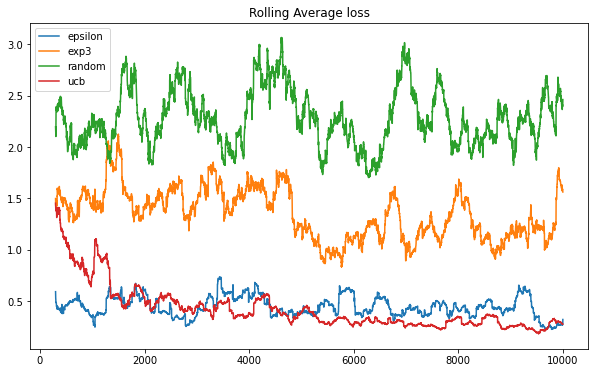

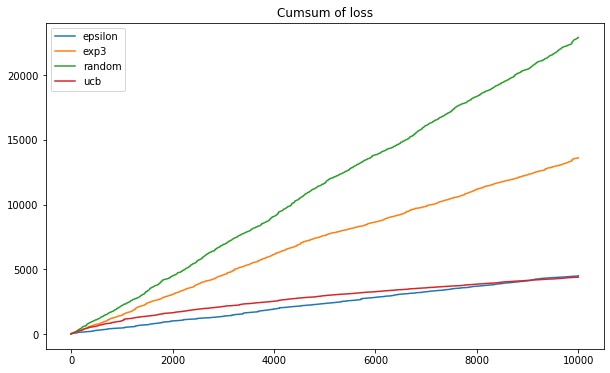

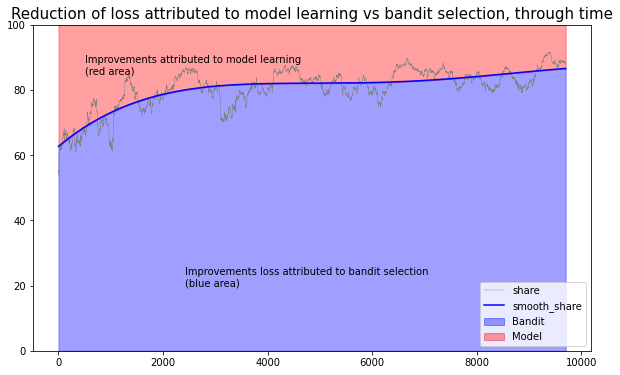

In [41]:
metric_values_dict = {key:value.metric_values for key,value in bandits_select.items()}
metric_values_df = pd.DataFrame(metric_values_dict)

metric_values_df.rolling(300).mean().plot(title="Rolling Average loss", figsize=FIGSIZE)
metric_values_df.cumsum().plot(title="Cumsum of loss", figsize=FIGSIZE)
selection_effect = make_compare_bandit_models_df(metric_values_df.drop(columns="exp3"), rolling_value=300, smoothing_degree=4)
make_compare_area_plot(selection_effect)

#### Rewards

<AxesSubplot:title={'center':'Reduction of loss attributed to model learning vs bandit selection, through time'}>

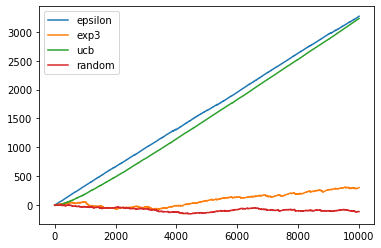

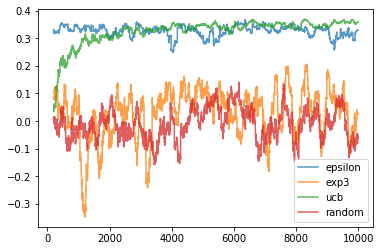

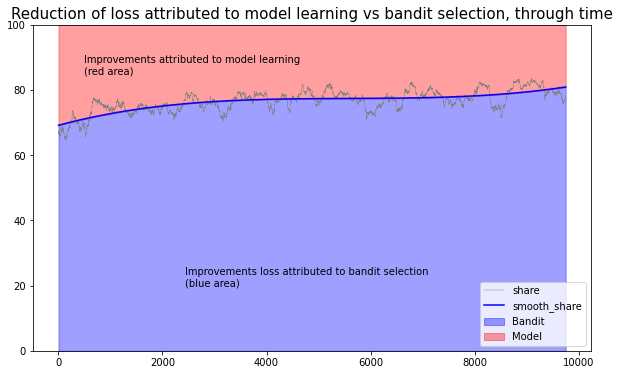

In [32]:
pd.DataFrame(bandits_rewards).cumsum().plot()
pd.DataFrame(bandits_rewards).rolling(200).mean().plot(alpha=.75)

reward_share_df = make_compare_bandit_models_df(metric_values_df, trans=lambda s: c*(s.random/(s + s.random)))
make_compare_area_plot(reward_share_df)

## TODO

- Regret analysis
- introducing break/shift in the data generating process
- adding new models on the fly
